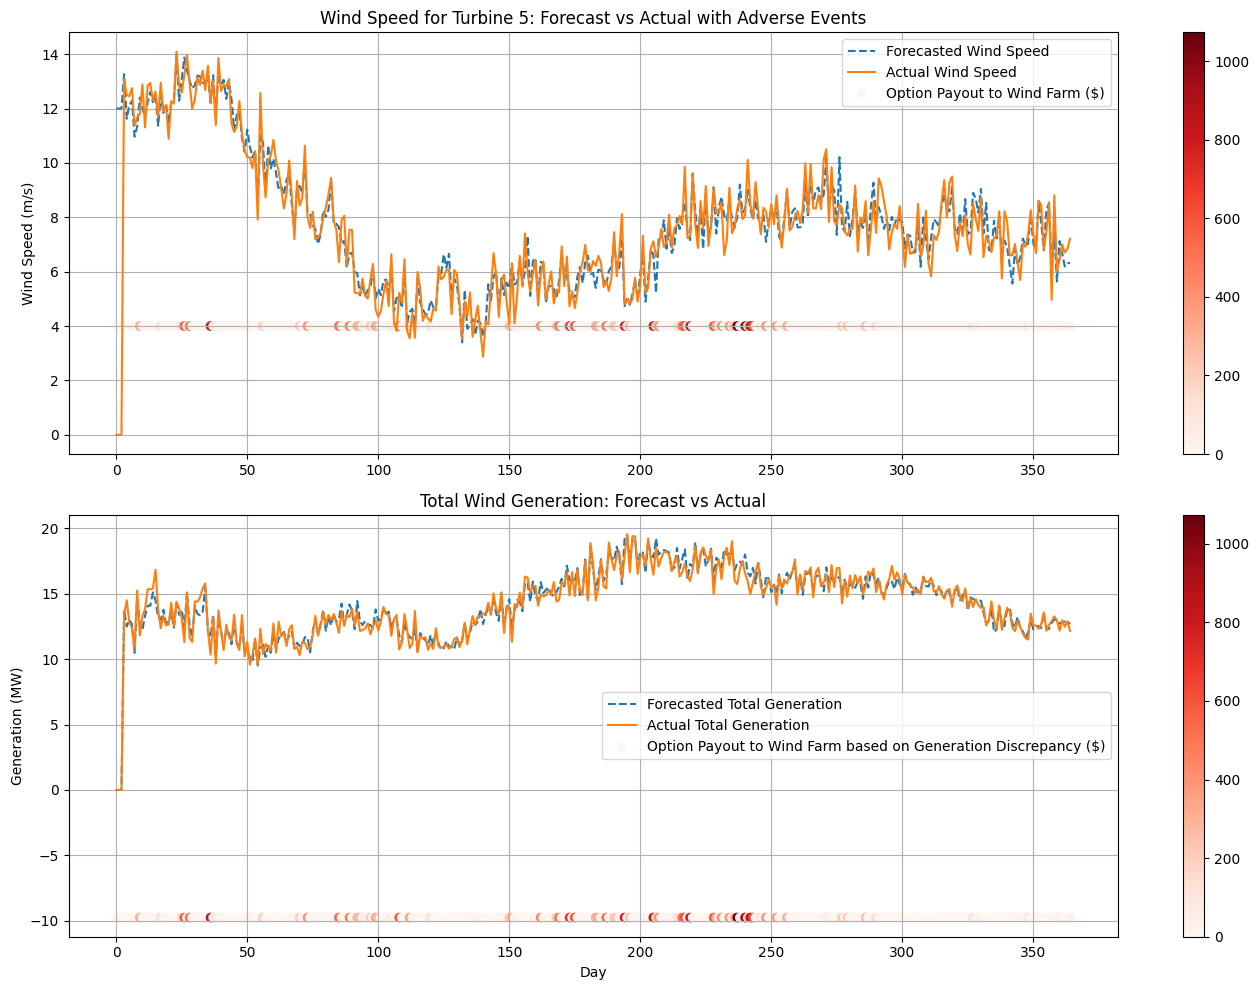

In [3]:
#  Libraries
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------
# Introduction
# -----------------------------------------------------

"""
Wind farm operators are susceptible to unpredictable weather events, such as icing on wind turbines.
These events are challenging to forecast and can significantly hamper power generation, leading to financial losses.

To mitigate this risk, the wind farm owner contemplates a weather derivative, structured as a call option.
By paying a premium, the owner can potentially claim a payout if actual generation deviates from the forecast, especially during adverse events.

This notebook uses advanced forecasting techniques to simulate this scenario, then visualizes the possible discrepancies and the ensuing payouts.
"""

# -----------------------------------------------------
# Constants for the Simulation
# -----------------------------------------------------

DAYS = 365
TURBINES = 10
BASE_WIND_SPEED = 12  # m/s
CUT_IN_SPEED = 3.5
RATED_SPEED = 14
CUT_OUT_SPEED = 25
RATED_POWER = 2.5  # MW

FORECAST_LAG_DAYS = 3
FORECAST_WEIGHTS = [0.5, 0.3, 0.2]
FORECAST_ERROR_STD = 0.75

STRIKE_LEVEL = 0.5  # MW discrepancy
TICK_SIZE = 1000  # $/MW discrepancy
OPTION_PREMIUM = 50000  # $ per turbine

# -----------------------------------------------------
# Helper Functions
# -----------------------------------------------------

def option_payoff(discrepancy, strike, tick_size):
    return max(0, (discrepancy - strike) * tick_size)

def wind_speed_to_power(speed):
    """Realistic wind turbine power curve."""
    if speed <= CUT_IN_SPEED or speed >= CUT_OUT_SPEED:
        return 0
    elif speed <= RATED_SPEED:
        return RATED_POWER * ((speed - CUT_IN_SPEED) / (RATED_SPEED - CUT_IN_SPEED))**3
    else:
        return RATED_POWER

# -----------------------------------------------------
# Main Simulation
# -----------------------------------------------------

# Initializing wind speeds and generations
forecasted_wind_speeds = np.zeros((DAYS, TURBINES))
actual_wind_speeds = np.zeros((DAYS, TURBINES))
forecasted_generation = np.zeros((DAYS, TURBINES))
actual_generation = np.zeros((DAYS, TURBINES))

# First few days are based on BASE_WIND_SPEED
forecasted_wind_speeds[:FORECAST_LAG_DAYS] = BASE_WIND_SPEED

for day in range(FORECAST_LAG_DAYS, DAYS):
    for turbine in range(TURBINES):
        # Use weighted average of previous days as forecast
        forecast = np.dot(forecasted_wind_speeds[day-FORECAST_LAG_DAYS:day, turbine], FORECAST_WEIGHTS)
        forecasted_wind_speeds[day, turbine] = forecast + np.random.normal(0, FORECAST_ERROR_STD)

        # Actual wind speeds are slightly deviated from forecasted values
        actual_wind_speeds[day, turbine] = forecasted_wind_speeds[day, turbine] + np.random.normal(0, 0.5)

        # Convert wind speeds to power
        forecasted_generation[day, turbine] = wind_speed_to_power(forecasted_wind_speeds[day, turbine])

        # Icing events - 10% efficiency drop on random days
        icing_factor = 0.9 if np.random.rand() < 0.05 else 1.0
        actual_generation[day, turbine] = icing_factor * wind_speed_to_power(actual_wind_speeds[day, turbine])

# Summing across turbines for total generation
total_forecasted_generation = forecasted_generation.sum(axis=1)
total_actual_generation = actual_generation.sum(axis=1)

# Computing discrepancies and payouts
generation_discrepancies = total_forecasted_generation - total_actual_generation
option_payouts = np.vectorize(option_payoff)(generation_discrepancies, STRIKE_LEVEL, TICK_SIZE)

# -----------------------------------------------------
# Visualization
# -----------------------------------------------------

plt.figure(figsize=(14, 10))

# Plotting forecasted vs actual wind speeds for a sample turbine
turbine_sample = 5
plt.subplot(2, 1, 1)
plt.plot(forecasted_wind_speeds[:, turbine_sample], label='Forecasted Wind Speed', linestyle='--')
plt.plot(actual_wind_speeds[:, turbine_sample], label='Actual Wind Speed')
plt.scatter(range(DAYS), [BASE_WIND_SPEED - 8] * DAYS, c=option_payouts, cmap='Reds', label='Option Payout to Wind Farm ($)')
plt.colorbar()
plt.title(f"Wind Speed for Turbine {turbine_sample}: Forecast vs Actual with Adverse Events")
plt.ylabel("Wind Speed (m/s)")
plt.legend()
plt.grid(True)

# Plotting forecasted vs actual total wind power generation
plt.subplot(2, 1, 2)
plt.plot(total_forecasted_generation, label='Forecasted Total Generation', linestyle='--')
plt.plot(total_actual_generation, label='Actual Total Generation')
plt.scatter(range(DAYS), [-0.5 * max(total_forecasted_generation)] * DAYS, c=option_payouts, cmap='Reds', label='Option Payout to Wind Farm based on Generation Discrepancy ($)')
plt.colorbar()
plt.title(f"Total Wind Generation: Forecast vs Actual")
plt.xlabel("Day")
plt.ylabel("Generation (MW)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
